# Challenge!

En este notebook vamos a trabajar sobre el siguiente desafio:

**Obtener por cohort (Mes de activacion de usuario):**
- **Churn Rate:** Numero de personas que hicieron churn
- **Retention Rate:** 1 - Churn Rate

Y la metrica:

- **Average Revenue Per User:**
    
    Volumen proceasdo (en USD) / total users.
    

Una vez obtenida esta información, el LTV se puede calcular como = ARPU / CHURN.

**Extra:**
- Modelos de Prediccion de Churn


**Autor**: Alan Matys, [LinkedIn](https://www.linkedin.com/in/alanmatys/)


## Instalacion de Spark

Primero Instalamos la libreria de Pyspark para poder levantar los datasets cargados en el Drive.

**Que beneficios tiene utilizar Spark por sobre un Pandas DataFrame?**

- Computo distribuido en un Cluster administrado por el Cluster Manager, le permite una gran velocidad
- Gran capacidad de procesamiento para grandes volumenes de datos, mo tiene la restriccion de la capacidad de RAM

In [ ]:
!pip install pyspark;

     |████████████████████████████████| 281.4 MB 32 kB/s 
     |████████████████████████████████| 198 kB 45.3 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=df7d1e0f5ed873a4676bff22c1e5276d51e56eabb6465a68e9cc674760234fe5
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


Cargamos las librerias que vamos a utilizar tanto en esta etapa como de manera posterior

Seteamos la sesion en Spark, dado que la Notebook esta montada sobre Google Colab, la cantidad de recursos que disponibiliza esta fijo en 2.

In [ ]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, functions as F
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import pyspark.ml.feature as pyml
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator


In [ ]:
# Seteo de Session en Spark
spark = (
    SparkSession
        .builder
        .master('local[2]')
        .appName('lemonspark')
        .getOrCreate()
)

## Lectura de Datos

Cargo los Dataframes previamente cargados en un drive y los visualizo para observar la estructura de los datos

In [ ]:
########## Cargo los archivos desde el Drive ################
archivo_users = '/content/drive/MyDrive/LemonChallenge/users.csv'
dfsp_users = spark.read.csv(archivo_users, inferSchema=True, header=True)

archivo_transacciones = '/content/drive/MyDrive/LemonChallenge/transactions.csv'
dfsp_transacciones = spark.read.csv(archivo_transacciones, inferSchema=True, header=True)

archivo_rates = '/content/drive/MyDrive/LemonChallenge/rates.csv'
dfsp_rates = spark.read.csv(archivo_rates, inferSchema=True, header=True)

######### Impresion de archivos para visualizar como se ven ##########
dfsp_transacciones.show()
dfsp_users.show()
dfsp_rates.show()

+--------------------+-------+---------+-----+--------------+------------------+--------+-------------------+
|                  id|user_id|   amount|state|operation_type|  transaction_type|currency|          createdat|
+--------------------+-------+---------+-----+--------------+------------------+--------+-------------------+
|00024dce-8d40-4ae...|3222205|   100.02| DONE|        CREDIT|       CRYPTO_SALE|   MONEY|2022-03-03T14:36:05|
|002da6df-ab3d-46a...|1058316|   1060.0| DONE|         DEBIT|LEMON_CARD_PAYMENT|   MONEY|2022-03-20T22:17:37|
|0035b8cf-d08e-4a3...|3245984|   349.27| DONE|        CREDIT|       CRYPTO_SALE|   MONEY|2022-01-21T06:10:52|
|0078c4a7-83ec-4a7...|4430720|   1440.0| DONE|         DEBIT|LEMON_CARD_PAYMENT|   MONEY|2022-03-16T12:52:18|
|0085edff-1129-424...|3193610|    100.0| DONE|         DEBIT|   CRYPTO_PURCHASE|   MONEY|2022-02-10T19:22:23|
|00ffd51e-3f84-46b...|2393552|1.5365E-4| DONE|         DEBIT|       CRYPTO_SALE|     BTC|2022-02-05T13:47:21|
|0103abf2-

## Busqueda de NA en el Dataframe

Creo una lista para iterar por cada uno de los dataframes, para cada una de sus columnas, intentar de visualizar si hay algun NA.

Se observan 8 observaciones con NA en el atributo **Gender**, correspondiente al Dataframe the **users**.

**Al no ser un atributo que nos afecte en el calculo de las metricas no se eliminan las observaciones, ni se le imputan valores**

In [ ]:
############# Busco Valores Nulos en cada uno de los Dataframes ###########
dfsp_list = [dfsp_transacciones,dfsp_rates,dfsp_users]
for df in dfsp_list:
  print(str(df))
  df.select(*[
      (
          F.count(F.when((F.isnan(c) | F.col(c).isNull()), c)) if t not in ("timestamp", "date")
          else F.count(F.when(F.col(c).isNull(), c))
      ).alias(c)
      for c, t in df.dtypes
  ]).show()

del(dfsp_list)
print('Hay solo un %',str(round(100*8/dfsp_users.count(),4)),'de NA Pero como no son de una variable relevante al problema no se eliminan')

######## Drop de los usuarios con na, dado que son pocos ###########
#dfsp_users = dfsp_users.filter('gender IS NOT NULL')

DataFrame[id: string, user_id: int, amount: double, state: string, operation_type: string, transaction_type: string, currency: string, createdat: string]
+---+-------+------+-----+--------------+----------------+--------+---------+
| id|user_id|amount|state|operation_type|transaction_type|currency|createdat|
+---+-------+------+-----+--------------+----------------+--------+---------+
|  0|      0|     0|    0|             0|               0|       0|        0|
+---+-------+------+-----+--------------+----------------+--------+---------+

DataFrame[base_currency: string, quote_currency: string, price: double]
+-------------+--------------+-----+
|base_currency|quote_currency|price|
+-------------+--------------+-----+
|            0|             0|    0|
+-------------+--------------+-----+

DataFrame[user_id: int, gender: string, birthdate: string, createdat: timestamp]
+-------+------+---------+---------+
|user_id|gender|birthdate|createdat|
+-------+------+---------+---------+
|    

## Exploratorio Transacciones

################ Tipos De Monedas Transaccionadas: ###############
DOT
ETH
MANA
SAND
MONEY
SLP
USDC
LUNA
BTC
DAI
AXS
USDT
UNI
SOL
ADA
ALGO


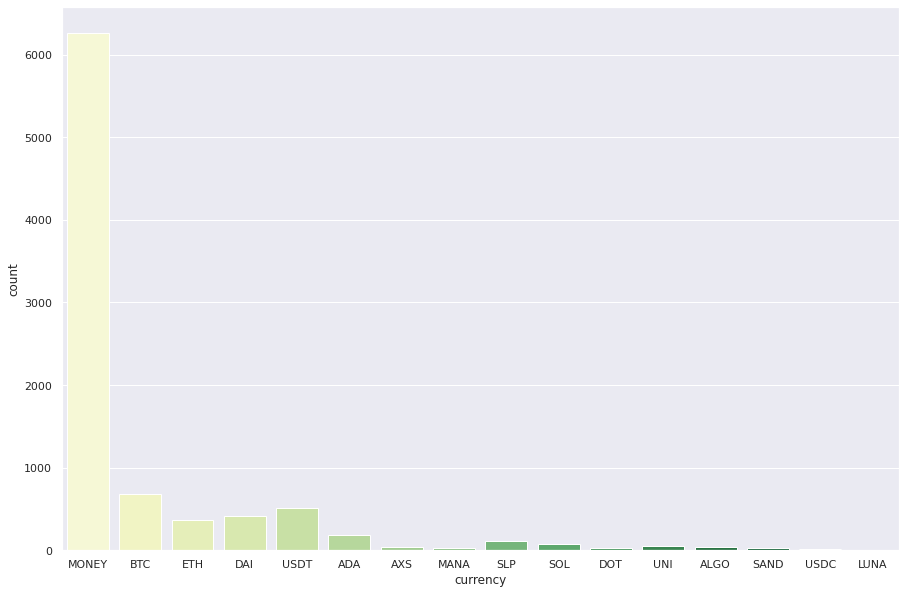

In [ ]:
#from locale import currency
######## Que tipos de currency hay? ###############
cur = dfsp_transacciones.select('currency').distinct().collect()
print('################ Tipos De Monedas Transaccionadas: ###############\n'+'\n'.join(str(cur[i][0]) for i in range(len(cur))))
sns.set(rc={'figure.figsize':(15,10)})
sns.countplot(data = dfsp_transacciones.toPandas(),x='currency',palette='YlGn')

############ Tipos De Transacciones: ################
LEMON_CARD_PAYMENT
VIRTUAL_WITHDRAWAL
VIRTUAL_DEPOSIT
CASH_IN_CRYPTO
CRYPTO_SALE
CRYPTO_SWAP
CRYPTO_PURCHASE


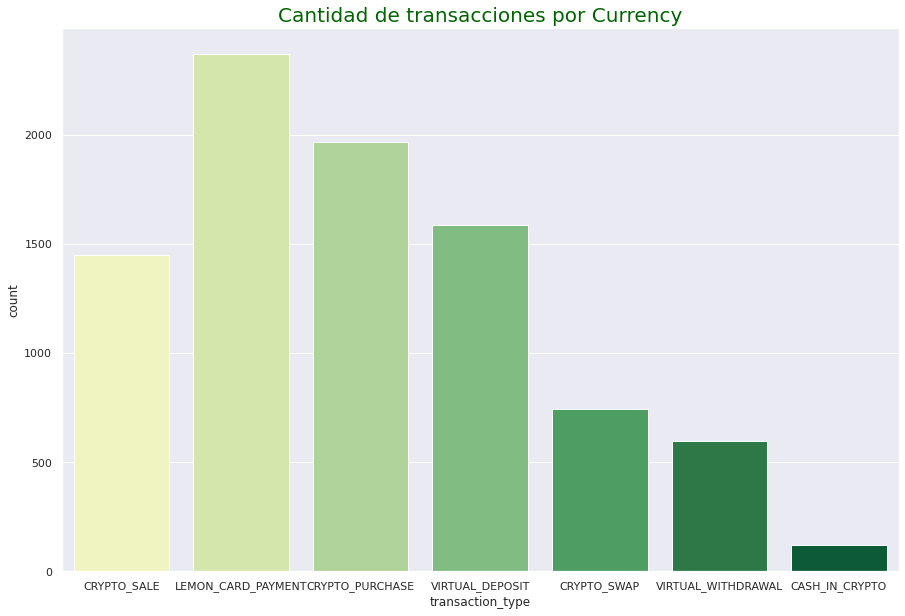

In [ ]:
######## Que tipos de transacciones hay? ###############
tr = dfsp_transacciones.select('transaction_type').distinct().collect()
print('############ Tipos De Transacciones: ################\n'+'\n'.join(str(tr[i][0]) for i in range(len(tr))))
sns.set(rc={'figure.figsize':(15,10)})
sns.countplot(data = dfsp_transacciones.toPandas(),x='transaction_type',palette='YlGn')
plt.title('Cantidad de transacciones por Currency',fontsize=20,color='darkgreen');

############# Tipos De Estados: ################
DONE
REJECTED
PENDING


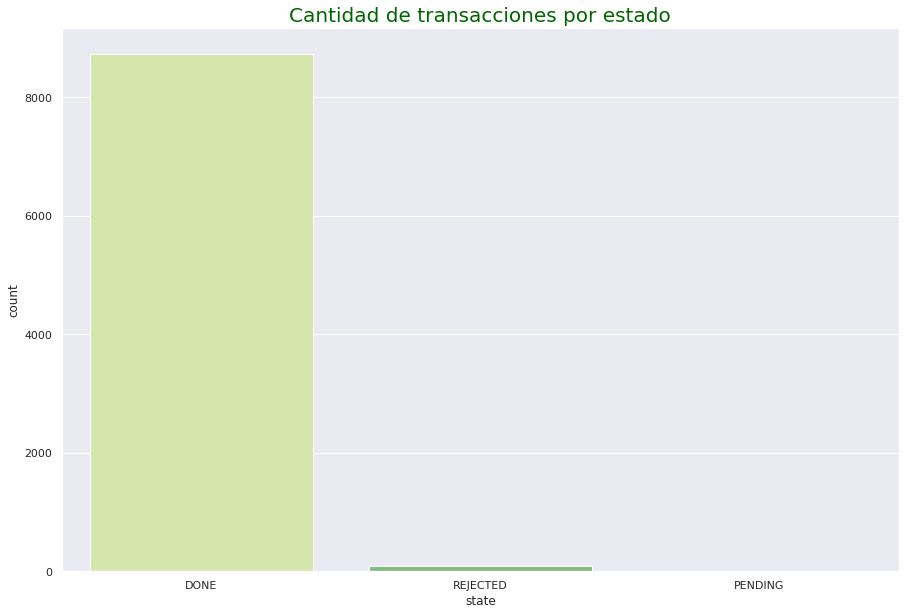

In [ ]:
######## Que tipos de estados hay? ###############
tr = dfsp_transacciones.select('state').distinct().collect()
print('############# Tipos De Estados: ################\n'+'\n'.join(str(tr[i][0]) for i in range(len(tr))))
sns.set(rc={'figure.figsize':(15,10)})
sns.countplot(data = dfsp_transacciones.toPandas(),x='state',palette='YlGn')
plt.title('Cantidad de transacciones por estado',fontsize=20,color='darkgreen');

El periodo que estamos analizando esta contemplado entre el:


**2021-08-30 01:52:03** al **2022-04-08 15:48:42**

In [ ]:
############ Entre que fechas hay transacciones ###############
fmax = dfsp_transacciones.agg(F.max(F.col('createdat'))).collect()[0][0]
fmin = dfsp_transacciones.agg(F.min(F.col('createdat'))).collect()[0][0]
print(fmin)
print(fmax)

2021-08-30T01:52:03
2022-04-08T15:48:42


Dado el Dataframe de Transacciones **solo 380 Usuarios son los que transaccionaron**

In [ ]:
####################### Cuantos Clientes hay? (Usuarios que transaccionaron) ##############
dfsp_transacciones.select(F.countDistinct("user_id").alias('Active Users')).show()

+------------+
|Active Users|
+------------+
|         380|
+------------+



# Calculo Churn

Primero para el calculo del churn creamos un proceso de feature engineering o ingenieria de atributos para el DataFrame de transacciones en donde:

- Convertimos la columna a formato time stamp y creamos una nueva con la conversion en tipo date


- Utilizando el Dataframe de Rates, nos quedamos con **solo las conversiones a USDT**, luego joineamos con el Dataframe de Transacciones (Dropeando la columna de *quote currency* para no tenerla repetida.

- Por ultimo:
    1.   Creamos la columna de **fee** tomando las tasas de fee tomadas en la consigna

    2.   Convertimos todas las *amount* con la informacion que tomamos de rates, solo para aquellas transacciones que fueron hechas en currencys que tienen conversion con USDT, para el resto tomamos su valor por defecto.

    3.   Al final de todo creamos la columna de *revenue*, con el producto amount corregido x *fee* 



In [ ]:
def feature_eng(df_tran,df_rates):
  """
  Funcion designada para la limpieza de datos
  """
######################## Limpieza de Fechas #############################
  df_tran = df_tran.withColumn('createdat', F.to_timestamp('createdat'))
  df_tran = df_tran.withColumn("fecha_create",F.to_date("createdat"))

###################### Paso todo a Money #################################
  df_rates = df_rates.filter('quote_currency == "USDT"').withColumnRenamed('base_currency','currency')
  df_tran = df_tran.join(df_rates,on='currency',how='left').drop('quote_currency')

####################### Agregar fee y Revenue ############################
  fee = F.expr("""IF(transaction_type == 'LEMON_CARD_PAYMENT', 0.05, IF(transaction_type == 'CRYPTO_SWAP', 0.01, IF((transaction_type == 'CRYPTO_SALE' || transaction_type == 'CRYPTO_PURCHASE'), 0.03,0)))""")
  df_tran = df_tran.withColumn('fee',fee)
  df_tran = df_tran.withColumn('amount',F.when(F.col('price').isNull(),df_tran.amount).otherwise(F.round((df_tran.price*df_tran.amount),2)))
  #df_tran = df_tran.withColumn('revenue',F.when(F.col('price').isNull(),df_tran.amount*df_tran.fee).otherwise(df_tran.price*df_tran.amount*df_tran.fee)).drop('price')
  df_tran = df_tran.withColumn('revenue',(df_tran.amount*df_tran.fee)).drop('price')

  return df_tran  

In [ ]:
dfsp_transacciones = feature_eng(dfsp_transacciones,dfsp_rates)
dfsp_transacciones.show()

+--------+--------------------+-------+-------+-----+--------------+------------------+-------------------+------------+----+--------+
|currency|                  id|user_id| amount|state|operation_type|  transaction_type|          createdat|fecha_create| fee| revenue|
+--------+--------------------+-------+-------+-----+--------------+------------------+-------------------+------------+----+--------+
|   MONEY|00024dce-8d40-4ae...|3222205| 100.02| DONE|        CREDIT|       CRYPTO_SALE|2022-03-03 14:36:05|  2022-03-03|0.00|     0.0|
|   MONEY|002da6df-ab3d-46a...|1058316| 1060.0| DONE|         DEBIT|LEMON_CARD_PAYMENT|2022-03-20 22:17:37|  2022-03-20|0.05|    53.0|
|   MONEY|0035b8cf-d08e-4a3...|3245984| 349.27| DONE|        CREDIT|       CRYPTO_SALE|2022-01-21 06:10:52|  2022-01-21|0.00|     0.0|
|   MONEY|0078c4a7-83ec-4a7...|4430720| 1440.0| DONE|         DEBIT|LEMON_CARD_PAYMENT|2022-03-16 12:52:18|  2022-03-16|0.05|    72.0|
|   MONEY|0085edff-1129-424...|3193610|  100.0| DONE|  

Luego creamos la funcion **last_seen**, la cual recibe el DataFrame de *Transacciones* y el de *Usuarios*.

- Primero agrupando por usuario crea los siguientes campos:
    - *last_seen:* fecha de ultima transaccion
    - *client_since:* fecha de su **primera** transaccion

  Y los agrupa en el Dataframe de *Usuarios*

**CONDICION DE CHURN**
- Luego creo el atributo de *churn* el cual esta definido de la siguiente manera:

  **Todo Usuario que su ultima transaccion fue antes del 2022-03-08 (dado que es 1 mes para atras desde la ultima fecha disponible en el dataset) Y que su fecha de creacion de usuario fue antes de Marzo**

  Esta columna la agrego tambien al Dataset de *Usuarios*

**Extra**

Pensando en un posible algoritmo de prediccion de churn incorporo las siguientes variables al Dataframe de *Usuarios*

- *volumen_total:* Monto total de transacciones realizadas.
- *transaccion_promedio:* Monto promedio de transacciones realizadas.
- *revenue:* Suma de Revenue por Usuario.

Tambien puede llegar a ser explicativo del *churn* cantidad de transacciones que realiza por cada tipo de currency:
- *q_ADA*, *q_BTC*, *q_DAI*, etc.

Y por ultimo calculo la edad de cada uno de los usuarios.

In [ ]:
def last_seen(df_tran,df_user):

############# Agrego Fecha de su ultima transaccion y me quedo SOLO con los Clientes #####################
  df_ls = df_tran.groupBy('user_id').agg(F.max('createdat').alias('last_seen'),F.min('createdat').alias('client_since'))
  df_ls = df_ls.withColumn('month_client',F.date_format('client_since','yyyy-MM'))
  df_user = df_user.join(df_ls,on='user_id',how='left').filter('last_seen IS NOT NULL')

############# Agrego Churn ###############################################################################
  churn = F.expr("""IF((last_seen < '2022-03-08') AND createdat < '2022-03-01', 1,0)""")
  df_user = df_user.withColumn('churn',churn)
  df_user = df_user.withColumn('creation_date',F.to_date('createdat'))

############# Agrego montos transaccionales ###############################################

  df_tr = (df_tran
           .filter('state == "DONE" ')
           .groupBy('user_id')
           .agg(F.sum('amount').alias('volumen_total'),
                F.mean('amount').alias('transaccion_promedio'),
                F.sum('revenue').alias('revenue'))
  )
  df_user = df_user.join(df_tr,on='user_id',how='left')

############ Agrego Cantidad de transacciones por Currency ################################################
  q_cur = df_tran.groupBy("user_id").pivot("currency").count().fillna(0)
  q_cur = q_cur.select([F.col(c).alias("q_"+c) for c in q_cur.columns]).withColumnRenamed('q_user_id', 'user_id')
  df_user = df_user.join(q_cur,on='user_id',how='left')

############ Agrego Cantidad de transacciones por tipo de transaccion  ################################################
  q_tran = df_tran.groupBy("user_id").pivot("transaction_type").count().fillna(0)
  q_tran = q_tran.select([F.col(c).alias("q_"+c) for c in q_tran.columns]).withColumnRenamed('q_user_id', 'user_id')
  df_user = df_user.join(q_tran,on='user_id',how='left')

###################### Agrego Edad del usuario ############################

  df_user = df_user.withColumn("Edad",F.floor(F.months_between(F.current_date(),F.col("birthdate"))/F.lit(12)))

  df_user.groupBy('churn').agg(F.count('user_id')).show()
  return df_user

In [ ]:
df_test = last_seen(dfsp_transacciones,dfsp_users)
df_test.show()

+-----+--------------+
|churn|count(user_id)|
+-----+--------------+
|    1|           106|
|    0|           274|
+-----+--------------+

+-------+------+----------+-------------------+-------------------+-------------------+------------+-----+-------------+------------------+--------------------+------------------+-----+------+-----+-----+-----+-----+-----+------+------+-------+------+-----+-----+-----+------+------+----------------+-----------------+-------------+-------------+--------------------+-----------------+--------------------+----+
|user_id|gender| birthdate|          createdat|          last_seen|       client_since|month_client|churn|creation_date|     volumen_total|transaccion_promedio|           revenue|q_ADA|q_ALGO|q_AXS|q_BTC|q_DAI|q_DOT|q_ETH|q_LUNA|q_MANA|q_MONEY|q_SAND|q_SLP|q_SOL|q_UNI|q_USDC|q_USDT|q_CASH_IN_CRYPTO|q_CRYPTO_PURCHASE|q_CRYPTO_SALE|q_CRYPTO_SWAP|q_LEMON_CARD_PAYMENT|q_VIRTUAL_DEPOSIT|q_VIRTUAL_WITHDRAWAL|Edad|
+-------+------+----------+----------

## Observaciones de aperturas por churn

### Insights
A nivel Transacciones que fueron realizadas(DONE) y que generaron **Revenue**:

- Se oberva que la mediana (%50) de Revenue es inferior en los usuarios que **SI** hicieron churn.

- Sin embargo el promedio, y los valores mas altos (%95) son Mayores en usuarios que **SI** hicieron churn. Con la salvedad de tener menos observaciones(aprox 10% de las transacciiones que No churn) y por lo tanto mayor desvio.

In [ ]:
df_join = df_test.select('churn','user_id')
plot_df2 = dfsp_transacciones.filter('state == "DONE" AND revenue > 0').join(df_join,on='user_id',how='left')

stats = ["50%","25%", "75%", "5%", "95%", "count", "mean", "stddev"]
print("############ Revenue por transacciones de Clientes que Realizaron Churn ########")
plot_df2.filter("churn = 1").select("revenue").summary(stats).show()
print("############ Revenue por transacciones de Clientes que NO Realizaron Churn ########")
plot_df2.filter("churn = 0").select("revenue").summary(stats).show()

############ Revenue por transacciones de Clientes que Realizaron Churn ########
+-------+-------------------+
|summary|            revenue|
+-------+-------------------+
|    50%|               10.0|
|    25%|0.08560000000000001|
|    75%|               80.0|
|     5%|             0.0116|
|    95%|            372.214|
|  count|                283|
|   mean| 140.92090493925804|
| stddev|  462.3345226580955|
+-------+-------------------+

############ Revenue por transacciones de Clientes que NO Realizaron Churn ########
+-------+------------------+
|summary|           revenue|
+-------+------------------+
|    50%|27.337500000000002|
|    25%| 4.290500000000001|
|    75%|              85.0|
|     5%|        0.01259333|
|    95%|          340.2035|
|  count|              2747|
|   mean|  91.3865588373393|
| stddev| 264.7841267339441|
+-------+------------------+



## Calculo de LTV

In [ ]:
mean_churn = df_test.groupby('month_client').agg((F.mean('churn')).alias('churn_rate')).sort(F.col('month_client').asc()).filter("month_client < '2022-04' ").agg(F.mean('churn_rate')).collect()[0][0]
arpu = dfsp_transacciones.filter('state == "DONE" ').agg(F.sum(F.col('revenue'))).collect()[0][0]/380

print(arpu/mean_churn)

1516.0720734711592


## Plot de Churn Rate vs Retention por cohort

  month_client  churn_rate
0      2021-08    1.000000
1      2021-09    0.500000
2      2021-10    0.714286
3      2021-11    0.461538
4      2021-12    0.454545
5      2022-01    0.450000
6      2022-02    0.348315
7      2022-03    0.111111


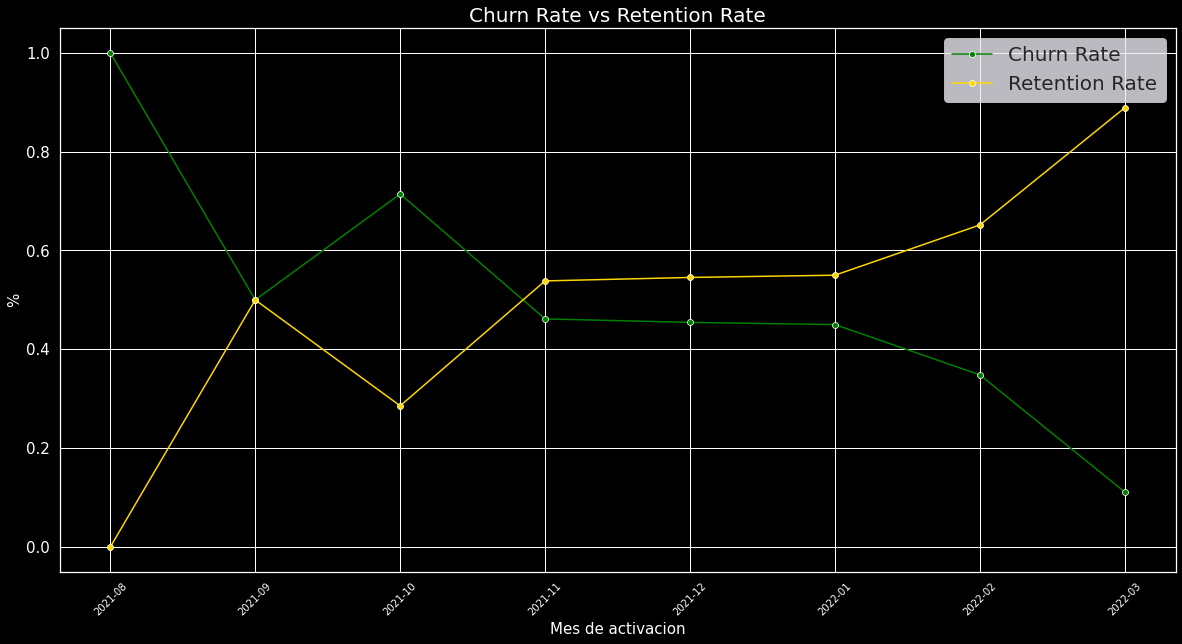

In [ ]:
plot_ret = df_test.groupby('month_client').agg((1-F.mean('churn')).alias('retention_rate')).filter("month_client < '2022-04' ").sort(F.col('month_client').asc()).toPandas()
plot_chur = df_test.groupby('month_client').agg((F.mean('churn')).alias('churn_rate')).filter("month_client < '2022-04' ").sort(F.col('month_client').asc()).toPandas()
fig, ax = plt.subplots(figsize=(20,10))
ax.set_facecolor('black')
fig.patch.set_facecolor('black')


sns.lineplot(x = "month_client", y = "churn_rate", data = plot_chur,ax=ax,color='green',label='Churn Rate', marker="o")
sns.lineplot(x = "month_client", y = "retention_rate", data = plot_ret,ax=ax,color='gold',label='Retention Rate', marker="o")
ax.set_ylabel('%',fontsize=15,color='white')
ax.set_xlabel('Mes de activacion',fontsize=15,color='white')
ax.set_title("Churn Rate vs Retention Rate", fontsize=20,color='white')
plt.yticks(fontsize=15,color='white')
plt.xticks(fontsize=10,rotation=45,color='White')
plt.legend(fontsize=20)

print(plot_chur)

## Insights 

Buscamos con un Boxplot:
- A ver si evidenciamos diferencias en Valor de transaccion promedio y Volumen total transaccionado entre usuarios que hicieron churn.
- Si hay diferenciacion notoria entre edades de personas que hicieron churn vs las que no

[(0.0, 175000.0)]

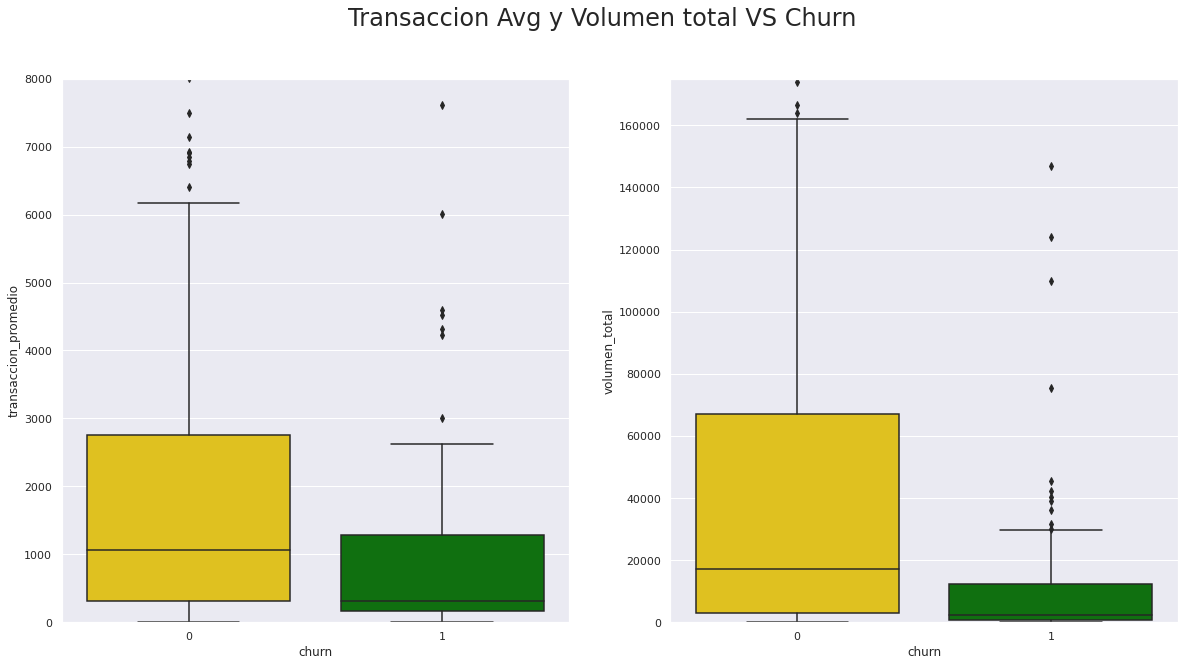

In [ ]:
ploti = df_test.toPandas()

fig, ax = plt.subplots(ncols=2,figsize=(20,10))
my_pal = {1: "green", 0: "gold"}

fig.suptitle('Transaccion Avg y Volumen total VS Churn', fontsize=24);
sns.boxplot(data=ploti,y='transaccion_promedio',x='churn',palette=my_pal,ax=ax[0])
sns.boxplot(data=ploti,y='volumen_total',x='churn',palette=my_pal,ax=ax[1])
ax[0].set(ylim=(0, 8000))
ax[1].set(ylim=(0, 175000))

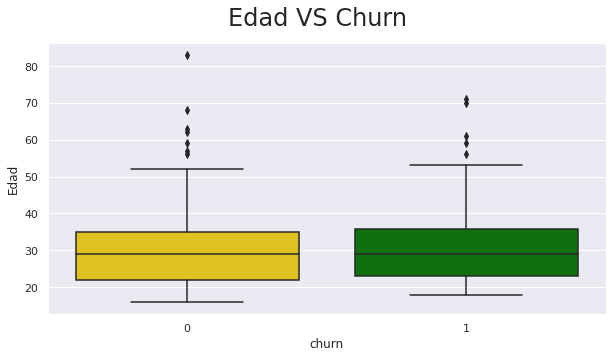

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
my_pal = {1: "green", 0: "gold"}

fig.suptitle('Edad VS Churn', fontsize=24);
sns.boxplot(data=ploti,y='Edad',x='churn',palette=my_pal,ax=ax)

## Modelado: Data Preparation
Previamente a correrr el algoritmo de prediccion de Churn, hay que preparar los datos. Los pasos son los siguientes:

**Categoricas:** Creamos un Pipeline para poder realizar las transformaciones necesarias



1.   Utilizamos un indexador de los **StringIndexer** que los convierte en Numeros para poder ser procesados.
2.   Luego utilizamos un **One Hot Encoder** para crear una columna booleana (1,0) para cada categoria posible del predictor.
3.   Por ultimo escalamos las variables para evitar que las distintas escalas por las que se mueven los predictores afecte la performance del modelo


In [ ]:
df_test.dtypes

[('user_id', 'int'),
 ('gender', 'string'),
 ('birthdate', 'string'),
 ('createdat', 'timestamp'),
 ('last_seen', 'timestamp'),
 ('client_since', 'timestamp'),
 ('month_client', 'string'),
 ('churn', 'int'),
 ('creation_date', 'date'),
 ('volumen_total', 'double'),
 ('transaccion_promedio', 'double'),
 ('revenue', 'double'),
 ('q_ADA', 'bigint'),
 ('q_ALGO', 'bigint'),
 ('q_AXS', 'bigint'),
 ('q_BTC', 'bigint'),
 ('q_DAI', 'bigint'),
 ('q_DOT', 'bigint'),
 ('q_ETH', 'bigint'),
 ('q_LUNA', 'bigint'),
 ('q_MANA', 'bigint'),
 ('q_MONEY', 'bigint'),
 ('q_SAND', 'bigint'),
 ('q_SLP', 'bigint'),
 ('q_SOL', 'bigint'),
 ('q_UNI', 'bigint'),
 ('q_USDC', 'bigint'),
 ('q_USDT', 'bigint'),
 ('q_CASH_IN_CRYPTO', 'bigint'),
 ('q_CRYPTO_PURCHASE', 'bigint'),
 ('q_CRYPTO_SALE', 'bigint'),
 ('q_CRYPTO_SWAP', 'bigint'),
 ('q_LEMON_CARD_PAYMENT', 'bigint'),
 ('q_VIRTUAL_DEPOSIT', 'bigint'),
 ('q_VIRTUAL_WITHDRAWAL', 'bigint'),
 ('Edad', 'bigint')]

In [ ]:
df_model = (
    df_test
 .withColumn("createdat", F.unix_timestamp(F.col("createdat"), "yyyy-MM-dd"))
 .withColumn("client_since", F.unix_timestamp(F.col("client_since"), "yyyy-MM-dd"))

)

In [ ]:
categorical_vars = ["gender", "month_client"]

In [ ]:
str_indexer = pyml.StringIndexer().setInputCols(categorical_vars).setOutputCols([ col + "Index" for col in categorical_vars])

In [ ]:
str_oh = pyml.OneHotEncoder().setInputCols([ col + "Index" for col in categorical_vars]).setOutputCols([ col + "OH" for col in categorical_vars])

In [ ]:
stages_df = [str_indexer, str_oh]

In [ ]:
mypipeline = Pipeline().setStages(stages_df)

In [ ]:
fitmodel = mypipeline.fit(df_model)

In [ ]:
df_model = fitmodel.transform(df_model)

In [ ]:
df_model.show()

+-------+------+----------+----------+-------------------+------------+------------+-----+-------------+------------------+--------------------+------------------+-----+------+-----+-----+-----+-----+-----+------+------+-------+------+-----+-----+-----+------+------+----------------+-----------------+-------------+-------------+--------------------+-----------------+--------------------+----+-----------+-----------------+-------------+--------------+
|user_id|gender| birthdate| createdat|          last_seen|client_since|month_client|churn|creation_date|     volumen_total|transaccion_promedio|           revenue|q_ADA|q_ALGO|q_AXS|q_BTC|q_DAI|q_DOT|q_ETH|q_LUNA|q_MANA|q_MONEY|q_SAND|q_SLP|q_SOL|q_UNI|q_USDC|q_USDT|q_CASH_IN_CRYPTO|q_CRYPTO_PURCHASE|q_CRYPTO_SALE|q_CRYPTO_SWAP|q_LEMON_CARD_PAYMENT|q_VIRTUAL_DEPOSIT|q_VIRTUAL_WITHDRAWAL|Edad|genderIndex|month_clientIndex|     genderOH|month_clientOH|
+-------+------+----------+----------+-------------------+------------+------------+-----+

## PipeLine Prediccion

Creamos un Pipeline para realziar la prediccion


1.   Primero creamos un **Vector Assembler** el cual consolida todas las columnas en una sola. Esto es necesario porque los algoritmos de ML de Spark operan en un solo vector de predictores (Variables Independientes). Sin embargo cada elemento del vector puede consistir de distintos valores


2.   Luego escalamos las variables, para evitar que las distintas escalas por las que se mueven cada una de las variables pueda llegar a afectar nuestra medicion.


3.   Por ultimo entrenamos nuestro algoritmo en estos datos y lo testeamos con nuestros datos de Test


4.   Una vez realizada la prediccion testeamos su capacidad con la metrica de Area bajo la curva ROC o AUCRoc, que es una metrica que no depende del punto de corte probabilistico. 
[Explicacion](https://es.wikipedia.org/wiki/Curva_ROC#:~:text=Curvas%20ROC%20para%20pruebas%20diagn%C3%B3sticas,-Diferentes%20curvas%20ROC&text=La%20elecci%C3%B3n%20se%20realiza%20mediante,prueba%20sin%20capacidad%20discriminatoria%20diagn%C3%B3stica.)


### Regresion Logistica

El primer algoritmo que vamos a probar es el de la **Logistic Regression** o **Regresion Logistica**.


- Este algoritmo utiliza una funcion logistica para modelar una variable Binaria (1,0).

- En una regresion logistica, el Eje X es una combinacion lineal de los predictores y el eje y es la salida del modelo o la probabilidad.

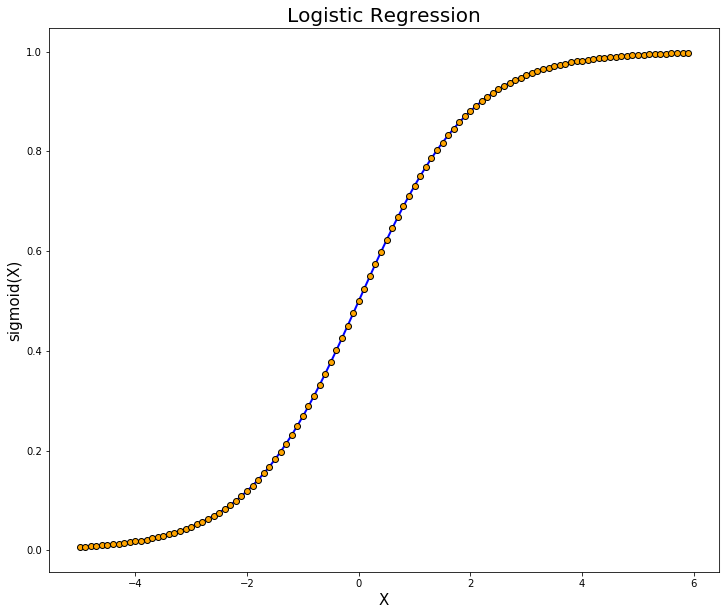


[Explicacion](https://es.wikipedia.org/wiki/Regresi%C3%B3n_log%C3%ADstica)

In [ ]:
splits = df_model.randomSplit([.8,.2], seed = 69)

In [ ]:
train_df = splits[0]

In [ ]:
test_df = splits[1]

In [ ]:
numeric_vars = [
  'createdat',
 'client_since',
 'volumen_total',
 'transaccion_promedio',
 'revenue',
 'q_ADA',
 'q_ALGO',
 'q_AXS',
 'q_BTC',
 'q_DAI',
 'q_DOT',
 'q_ETH',
 'q_LUNA',
 'q_MANA',
 'q_MONEY',
 'q_SAND',
 'q_SLP',
 'q_SOL',
 'q_UNI',
 'q_USDC',
 'q_USDT',
 'q_CRYPTO_PURCHASE',
 'q_CRYPTO_SALE',
 'q_CASH_IN_CRYPTO',
 'q_CRYPTO_SWAP',
 'q_LEMON_CARD_PAYMENT',
 'q_VIRTUAL_DEPOSIT',
 'q_VIRTUAL_WITHDRAWAL',
 'Edad']

In [ ]:
categorical_vars = [
  "genderOH",
  "month_clientOH"
]

In [ ]:
VectorAssembler = pyml.VectorAssembler().setInputCols(numeric_vars + categorical_vars).setOutputCol("features")

In [ ]:
scaler = pyml.StandardScaler().setInputCol("features").setOutputCol("scaledFeatures")

In [ ]:
predictor =  LogisticRegression().setFeaturesCol("scaledFeatures").setLabelCol("churn")


In [ ]:
pipeline_stages = [VectorAssembler, scaler, predictor]

In [ ]:
model_pipeline = Pipeline().setStages(pipeline_stages)

In [ ]:
model = model_pipeline.fit(train_df)

In [ ]:
results = model.transform(test_df)

In [ ]:
results.show()

+-------+------+----------+----------+-------------------+------------+------------+-----+-------------+------------------+--------------------+------------------+-----+------+-----+-----+-----+-----+-----+------+------+-------+------+-----+-----+-----+------+------+----------------+-----------------+-------------+-------------+--------------------+-----------------+--------------------+----+-----------+-----------------+-------------+--------------+--------------------+--------------------+--------------------+--------------------+----------+
|user_id|gender| birthdate| createdat|          last_seen|client_since|month_client|churn|creation_date|     volumen_total|transaccion_promedio|           revenue|q_ADA|q_ALGO|q_AXS|q_BTC|q_DAI|q_DOT|q_ETH|q_LUNA|q_MANA|q_MONEY|q_SAND|q_SLP|q_SOL|q_UNI|q_USDC|q_USDT|q_CASH_IN_CRYPTO|q_CRYPTO_PURCHASE|q_CRYPTO_SALE|q_CRYPTO_SWAP|q_LEMON_CARD_PAYMENT|q_VIRTUAL_DEPOSIT|q_VIRTUAL_WITHDRAWAL|Edad|genderIndex|month_clientIndex|     genderOH|month_clien

#### Metricas

In [ ]:
results.groupby(['churn','prediction']).count().show()

+-----+----------+-----+
|churn|prediction|count|
+-----+----------+-----+
|    1|       0.0|   10|
|    0|       0.0|   51|
|    1|       1.0|   13|
|    0|       1.0|    5|
+-----+----------+-----+



In [ ]:
evaluator = (
    BinaryClassificationEvaluator()
    .setLabelCol('churn')
    .setRawPredictionCol('prediction')
    .setMetricName('areaUnderROC')
)

accuracy = evaluator.evaluate(results)
print(accuracy)

0.7379658385093167


### Arbol de Decision

Reutilizando el Pipeline anterior pero cambiando su algoritmo predictor, utilizamos un **Decision Tree** o **Arbol de Decision**.


El Arbol de Decision es algoritmo que utiliza un recurso de particion recursiva. El cual analiza por cada uno de los posibles predictores, cual es el mejor corte para subdivirlos, tal que en cada una de las divisiones queden observaciones lo mas parecidas posibles.


Luego una vez creadas las particiones del arbol con las observaciones de entrenamiento, se hacen pasar las observaciones por el arbol construido para obtener una valor de prediccion.

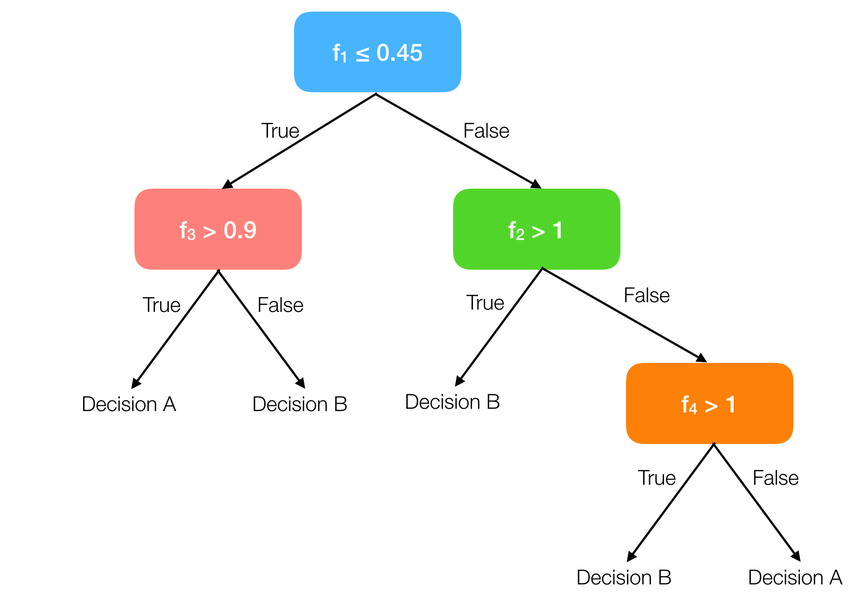


[Explicacion](https://es.wikipedia.org/wiki/Aprendizaje_basado_en_%C3%A1rboles_de_decisi%C3%B3n)

In [ ]:
predictor = DecisionTreeClassifier().setFeaturesCol("scaledFeatures").setLabelCol("churn")

In [ ]:
pipeline_stages = [VectorAssembler, scaler, predictor]

In [ ]:
model_pipeline = Pipeline().setStages(pipeline_stages)

In [ ]:
model = model_pipeline.fit(train_df)

In [ ]:
results = model.transform(test_df)

#### Metricas

In [ ]:
results.groupby(['churn','prediction']).count().show()

+-----+----------+-----+
|churn|prediction|count|
+-----+----------+-----+
|    1|       0.0|   13|
|    0|       0.0|   50|
|    1|       1.0|   10|
|    0|       1.0|    6|
+-----+----------+-----+



In [ ]:
auc_tree = evaluator.evaluate(results)
print(auc_tree)

0.6638198757763975


## Gradient Boosting Tree

El algoritmo de Gradient Boosting Trees utiliza un metodo iterativo que:


1.   Crea un arbol de Decision y lo agrega a un ensamble
2.   Genera una prediccion para cada instancia de entrenamiento utilizando el ensamble
3.   Compara la prediccion con el valor real
4.   Corrige las predicciones con una funcion de perdida
5.   Vuelve al paso 1.

El modelo mejora con cada iteracion

[Explicacion](https://es.wikipedia.org/wiki/Gradient_boosting)



In [ ]:
predictor = GBTClassifier(maxIter=10).setFeaturesCol("scaledFeatures").setLabelCol("churn")

In [ ]:
pipeline_stages = [VectorAssembler, scaler, predictor]

In [ ]:
model_pipeline = Pipeline().setStages(pipeline_stages)

In [ ]:
model = model_pipeline.fit(train_df)

In [ ]:
results = model.transform(test_df)

#### Metricas

In [ ]:
results.groupby(['churn','prediction']).count().show()

+-----+----------+-----+
|churn|prediction|count|
+-----+----------+-----+
|    1|       0.0|   10|
|    0|       0.0|   50|
|    1|       1.0|   13|
|    0|       1.0|    6|
+-----+----------+-----+



In [ ]:
auc_rf = evaluator.evaluate(results)
print(auc_rf)

0.7290372670807452
